## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import random

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

#assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
#assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [ ]:
text[:100]

"  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as "

### Data loading: "Евгений Онегин"


In [ ]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()

# text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [7]:
tokens = sorted(set(text))
print(len(tokens))

38


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
id_to_token = {idx: token for idx, token in enumerate(tokens)}
token_to_id = {token: idx for idx, token in enumerate(tokens)}

num_tokens = len(tokens)
text_encoded = [token_to_id[x] for x in text]

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
# Кодирование текста
text_encoded = [token_to_id[ch] for ch in text]

# Параметры модели
SEQ_LENGTH = 100  # Длина последовательности для обучения
HIDDEN_SIZE = 128  # Размер скрытого состояния
NUM_LAYERS = 2     # Количество слоев RNN
LEARNING_RATE = 0.005
NUM_EPOCHS = 100
BATCH_SIZE = 32

# Создание обучающих данных
def create_sequences(data, seq_length):
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + 1:i + seq_length + 1]
        sequences.append(seq)
        targets.append(target)

    return torch.tensor(sequences), torch.tensor(targets)

X, y = create_sequences(text_encoded, SEQ_LENGTH)

# Определение модели RNN
class ShakespeareRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(ShakespeareRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        # Размеры: x: (batch_size, seq_length)
        batch_size = x.size(0)

        if hidden is None:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        embedded = self.embedding(x)  # (batch_size, seq_length, hidden_size)
        output, hidden = self.rnn(embedded, hidden)
        output = self.fc(output)  # (batch_size, seq_length, output_size)

        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Инициализация модели
model = ShakespeareRNN(num_tokens, HIDDEN_SIZE, num_tokens, NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Обучение модели
train_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    # Перемешиваем данные
    indices = torch.randperm(len(X))
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    for i in range(0, len(X), BATCH_SIZE):
        batch_X = X_shuffled[i:i+BATCH_SIZE]
        batch_y = y_shuffled[i:i+BATCH_SIZE]

        optimizer.zero_grad()

        # Forward pass
        output, hidden = model(batch_X)

        # Reshape для loss функции
        output = output.reshape(-1, num_tokens)
        batch_y = batch_y.reshape(-1)

        loss = criterion(output, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / (len(X) / BATCH_SIZE)
    train_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}')

# Функция для генерации текста
def generate_text(model, start_text, length=500, temperature=0.8):
    model.eval()

    # Преобразуем начальный текст в последовательность индексов
    start_tokens = [token_to_id[ch] for ch in start_text.lower()]
    generated = start_tokens.copy()

    with torch.no_grad():
        hidden = None

        # Подаем начальную последовательность
        if len(start_tokens) > 1:
            input_seq = torch.tensor([start_tokens[:-1]]).long()
            output, hidden = model(input_seq)

        # Генерируем новые токены
        current_token = torch.tensor([[start_tokens[-1]]]).long()

        for _ in range(length):
            output, hidden = model(current_token, hidden)

            # Получаем вероятности следующего токена
            logits = output[0, -1, :] / temperature
            probabilities = torch.softmax(logits, dim=0)

            # Выбираем токен на основе вероятностей
            next_token = torch.multinomial(probabilities, 1).item()

            generated.append(next_token)
            current_token = torch.tensor([[next_token]]).long()

    # Преобразуем индексы обратно в текст
    generated_text = ''.join([id_to_token[token_id] for token_id in generated])

    return generated_text

# Генерация текста
print("\n" + "="*50)
print("ГЕНЕРАЦИЯ ТЕКСТА В СТИЛЕ ШЕКСПИРА")
print("="*50)

start_phrases = [
    "shall i compare thee",
    "my mistress eyes",
    "when i do count",
    "love is not love",
    "from fairest creatures"
]

for i, phrase in enumerate(start_phrases):
    generated = generate_text(model, phrase, length=300, temperature=0.7)
    print(f"\nПример {i+1} (стартовая фраза: '{phrase}'):")
    print("-" * 50)

    # Форматируем вывод как сонет
    lines = generated.split('\n')
    for j, line in enumerate(lines[:14]):  # Показываем первые 14 строк
        if j < 14:
            print(f"  {line}")

    if len(lines) > 14:
        print("  ...")
    print()

Epoch [10/100], Loss: 1.5683
Epoch [20/100], Loss: 1.4163
Epoch [30/100], Loss: 1.5018
Epoch [40/100], Loss: 1.5502
Epoch [50/100], Loss: 1.5363
Epoch [60/100], Loss: 1.5369
Epoch [70/100], Loss: 1.5518
Epoch [80/100], Loss: 1.5265
Epoch [90/100], Loss: 1.5365
Epoch [100/100], Loss: 1.5337

ГЕНЕРАЦИЯ ТЕКСТА В СТИЛЕ ШЕКСПИРА

Пример 1 (стартовая фраза: 'shall i compare thee'):
--------------------------------------------------
  shall i compare thee mine it so to chart's swart'right,
      what full other'd you art,
      that to time and the for thee ut thy her doth perk the thee;
    to date to the with prove, and self in some it for my state that the shall thee and ball like fair; thou have that green.
  
    cxxxvii
  
    what thy most preat the love t


Пример 2 (стартовая фраза: 'my mistress eyes'):
--------------------------------------------------
  my mistress eyes am of the bemongue-dord,
    more i not, and beauty in make disprest with mine, but un me of the sweet of and map

Plot the loss function (axis X: number of epochs, axis Y: loss function).

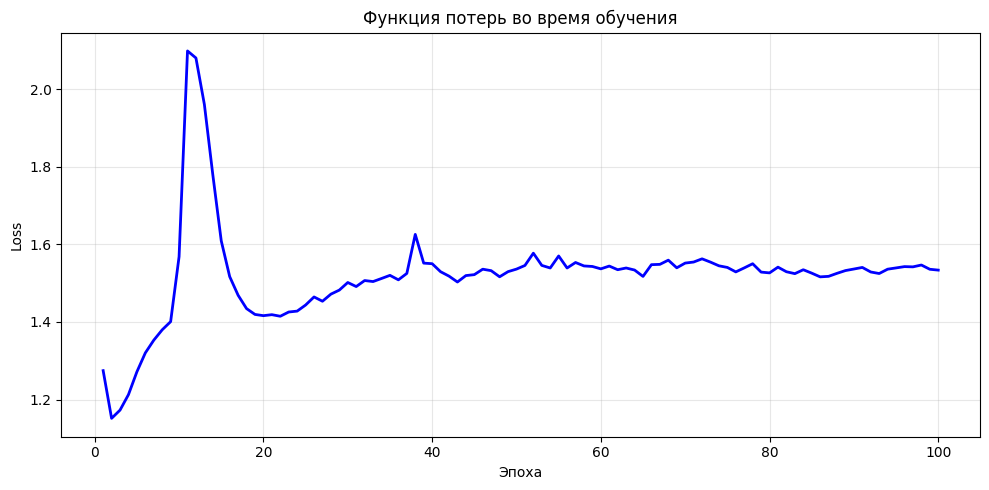

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Построение графика функции потерь
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'b-', linewidth=2)
plt.title('Функция потерь во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?


=== Обучение на 2000 примерах ===
Epoch [10/50], Loss: 0.5948
Epoch [20/50], Loss: 0.1376
Epoch [30/50], Loss: 0.1026
Epoch [40/50], Loss: 0.0124
Epoch [50/50], Loss: 0.1756

=== Результаты ===
LSTM финальный loss: 0.1756

=== Тест генерации ===

'shall i': shall if deep thy beauty's field beauty's legacy?
...

'love': loven and thriftless praise.
  how much more prais...

'my': ошибка генерации


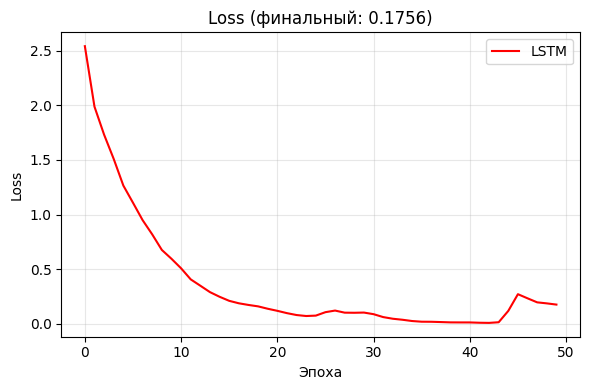

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Уменьшаем параметры для экономии вычислений
SEQ_LENGTH = 50    # Уменьшили длину последовательности
HIDDEN_SIZE = 64   # Уменьшили размер скрытого состояния
NUM_LAYERS = 1     # Используем только 1 слой
LEARNING_RATE = 0.01
NUM_EPOCHS = 50    # Уменьшили количество эпох
BATCH_SIZE = 16    # Уменьшили размер батча

# Создаем меньше данных для обучения
def create_subset_sequences(data, seq_length, subset_size=1000):
    """Создаем подмножество обучающих данных"""
    sequences = []
    targets = []

    # Берем только первые subset_size последовательностей
    limit = min(len(data) - seq_length, subset_size)
    for i in range(limit):
        seq = data[i:i + seq_length]
        target = data[i + 1:i + seq_length + 1]
        sequences.append(seq)
        targets.append(target)

    return torch.tensor(sequences), torch.tensor(targets)

# Используем меньше данных
X, y = create_subset_sequences(text_encoded, SEQ_LENGTH, subset_size=2000)

# Упрощенная модель LSTM
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        # Более простая архитектура
        self.embedding = nn.Embedding(input_size, hidden_size//2)  # Меньшая размерность эмбеддингов
        self.lstm = nn.LSTM(hidden_size//2, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        output, hidden = self.lstm(embedded, hidden)
        return self.fc(output), hidden

# Инициализация упрощенной модели
lstm_model = SimpleLSTM(num_tokens, HIDDEN_SIZE, num_tokens, NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
lstm_losses = []

print(f"\n=== Обучение на {len(X)} примерах ===")

for epoch in range(NUM_EPOCHS):
    lstm_model.train()
    total_loss = 0
    num_batches = 0

    # Обучаем на меньшем количестве батчей за эпоху
    max_batches = min(50, len(X) // BATCH_SIZE)  # Ограничиваем количество батчей

    indices = torch.randperm(len(X))
    X_shuffled, y_shuffled = X[indices], y[indices]

    for i in range(0, max_batches * BATCH_SIZE, BATCH_SIZE):
        batch_X = X_shuffled[i:i+BATCH_SIZE]
        batch_y = y_shuffled[i:i+BATCH_SIZE]

        lstm_optimizer.zero_grad()
        output, _ = lstm_model(batch_X)

        # Используем меньший контекст для вычисления loss
        loss = criterion(output[:, -10:, :].reshape(-1, num_tokens),  # Только последние 10 предсказаний
                        batch_y[:, -10:].reshape(-1))
        loss.backward()

        # Gradient clipping для стабильности
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=0.5)
        lstm_optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    if num_batches > 0:
        avg_loss = total_loss / num_batches
        lstm_losses.append(avg_loss)

    # Ранняя остановка если loss перестал улучшаться
    if len(lstm_losses) > 5 and abs(lstm_losses[-1] - lstm_losses[-5]) < 0.001:
        print(f"Ранняя остановка на эпохе {epoch+1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}')

print(f"\n=== Результаты ===")
if lstm_losses:
    print(f"LSTM финальный loss: {lstm_losses[-1]:.4f}")

# Упрощенная функция генерации
def generate_text_simple(model, start_text, length=80, temperature=0.8):
    model.eval()
    tokens = [token_to_id.get(ch, 0) for ch in start_text.lower()]  # Используем 0 для неизвестных символов
    if not tokens:
        return ""

    generated = tokens.copy()

    with torch.no_grad():
        hidden = None
        # Используем только последние 20 символов как контекст
        context_len = min(20, len(tokens)-1)
        if context_len > 0:
            _, hidden = model(torch.tensor([tokens[-context_len:-1]]).long())

        current = torch.tensor([[tokens[-1]]]).long()
        for _ in range(length):
            output, hidden = model(current, hidden)
            # Используем top-k sampling для ускорения
            logits = output[0, -1, :] / temperature
            top_k = min(10, num_tokens)
            top_logits, top_indices = torch.topk(logits, top_k)
            probs = torch.softmax(top_logits, dim=0)
            next_idx = torch.multinomial(probs, 1).item()
            next_token = top_indices[next_idx].item()

            generated.append(next_token)
            current = torch.tensor([[next_token]]).long()

            # Останавливаемся если сгенерировали слишком много
            if len(generated) >= 200:
                break

    return ''.join([id_to_token.get(t, '') for t in generated])

# Тест генерации
print("\n=== Тест генерации ===")
test_phrases = ["shall i", "love", "my"]

for phrase in test_phrases:
    try:
        text = generate_text_simple(lstm_model, phrase, length=60, temperature=0.7)
        print(f"\n'{phrase}': {text[:50]}...")
    except:
        print(f"\n'{phrase}': ошибка генерации")

# Простой график
if lstm_losses:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 4))
    plt.plot(lstm_losses, 'r-', label='LSTM')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.title(f'Loss (финальный: {lstm_losses[-1]:.4f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

Используем 20000 символов для обучения
Создано 3000 обучающих последовательностей
Используется устройство: cuda

=== ОБУЧЕНИЕ МОДЕЛИ (займет ~15-25 минут) ===
Обучающих примеров: 2700
Валидационных примеров: 300
Размер словаря: 38


Epoch 1/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 1: Train Loss = 2.9313, Val Loss = 2.4919, LR = 0.001000


Epoch 2/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 2: Train Loss = 2.2688, Val Loss = 2.0337, LR = 0.001000


Epoch 3/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 3: Train Loss = 1.9595, Val Loss = 1.8574, LR = 0.001000


Epoch 4/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 4: Train Loss = 1.7734, Val Loss = 1.7627, LR = 0.001000


Epoch 5/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 5: Train Loss = 1.6309, Val Loss = 1.7118, LR = 0.001000
Чекпоинт сохранен


Epoch 6/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 6: Train Loss = 1.5037, Val Loss = 1.7027, LR = 0.001000


Epoch 7/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 7: Train Loss = 1.3705, Val Loss = 1.7224, LR = 0.001000


Epoch 8/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 8: Train Loss = 1.2386, Val Loss = 1.7745, LR = 0.001000


Epoch 9/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 9: Train Loss = 1.1052, Val Loss = 1.8326, LR = 0.001000


Epoch 10/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 10: Train Loss = 0.9746, Val Loss = 1.9325, LR = 0.000500
Чекпоинт сохранен


Epoch 11/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 11: Train Loss = 0.8543, Val Loss = 1.9927, LR = 0.000500


Epoch 12/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 12: Train Loss = 0.7810, Val Loss = 2.0771, LR = 0.000500


Epoch 13/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 13: Train Loss = 0.7173, Val Loss = 2.1426, LR = 0.000500


Epoch 14/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 14: Train Loss = 0.6575, Val Loss = 2.2114, LR = 0.000250


Epoch 15/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 15: Train Loss = 0.6023, Val Loss = 2.2524, LR = 0.000250
Чекпоинт сохранен


Epoch 16/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 16: Train Loss = 0.5758, Val Loss = 2.2976, LR = 0.000250


Epoch 17/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 17: Train Loss = 0.5479, Val Loss = 2.3307, LR = 0.000250


Epoch 18/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 18: Train Loss = 0.5215, Val Loss = 2.3840, LR = 0.000125


Epoch 19/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 19: Train Loss = 0.5010, Val Loss = 2.3973, LR = 0.000125


Epoch 20/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 20: Train Loss = 0.4888, Val Loss = 2.4080, LR = 0.000125
Чекпоинт сохранен


Epoch 21/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 21: Train Loss = 0.4769, Val Loss = 2.4338, LR = 0.000125


Epoch 22/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 22: Train Loss = 0.4657, Val Loss = 2.4629, LR = 0.000063


Epoch 23/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 23: Train Loss = 0.4557, Val Loss = 2.4616, LR = 0.000063


Epoch 24/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 24: Train Loss = 0.4502, Val Loss = 2.4706, LR = 0.000063


Epoch 25/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 25: Train Loss = 0.4456, Val Loss = 2.4876, LR = 0.000063
Чекпоинт сохранен


Epoch 26/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 26: Train Loss = 0.4391, Val Loss = 2.4975, LR = 0.000031


Epoch 27/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 27: Train Loss = 0.4357, Val Loss = 2.5011, LR = 0.000031


Epoch 28/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 28: Train Loss = 0.4330, Val Loss = 2.5082, LR = 0.000031


Epoch 29/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 29: Train Loss = 0.4291, Val Loss = 2.5100, LR = 0.000031


Epoch 30/30:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 30: Train Loss = 0.4272, Val Loss = 2.5121, LR = 0.000016
Чекпоинт сохранен

=== ГЕНЕРАЦИЯ ТЕКСТА ПОСЛЕ ОБУЧЕНИЯ ===
Финальный train loss: 0.4272
Финальный val loss: 2.5121

Примеры генерации с разными параметрами:

Фраза: 'shall i compare thee'

Temperature=0.7 (консервативно):
----------------------------------------
shall i compare thee to be converted,
and some gilder die.
but dicture and mothers, in theart thou consum'st thy self
in single live?
for at a frown they in thee to

Temperature=1.2 (креативно):
----------------------------------------
shall i compare thee to be cow'll', on his plooquingle reep,

thy poqusing sing in thy noon:
o! lets for from they heart store to dimb
that in men hath my duty str

Фраза: 'my mistress eyes are'

Temperature=0.7 (консервативно):
----------------------------------------
my mistress eyes are fill'd with your most in compleated wit
h time for love of yet and of men.
to hear with eyes belongs to love's fine wit.

xxii

much call thee

Te

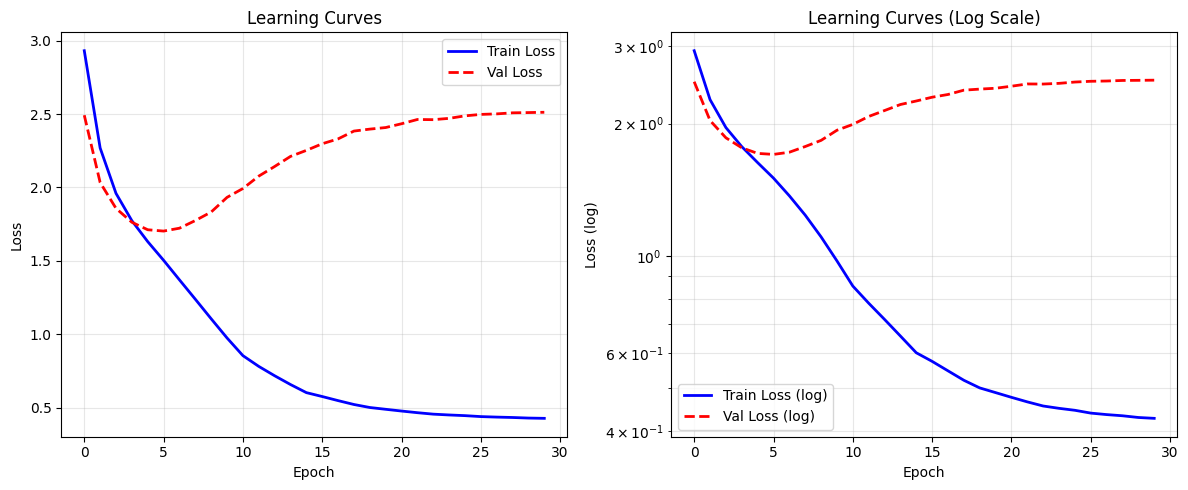

In [11]:
# Умеренные параметры для T4
SEQ_LENGTH = 80      # Средняя длина последовательности
HIDDEN_SIZE = 256    # Размер модели для хорошего качества
NUM_LAYERS = 2       # 2 слоя LSTM
LEARNING_RATE = 0.001
NUM_EPOCHS = 30      # 30 эпох
BATCH_SIZE = 64      # Оптимальный размер батча для T4

# Используем значительную часть данных (первые 20K символов)
train_size = min(20000, len(text_encoded))
train_data = text_encoded[:train_size]

print(f"Используем {train_size} символов для обучения")

# Создаем последовательности
def create_balanced_sequences(data, seq_length, max_sequences=5000):
    sequences = []
    targets = []

    # Используем сэмплирование с шагом для разнообразия
    step = max(1, (len(data) - seq_length) // max_sequences)

    for i in range(0, len(data) - seq_length, step):
        seq = data[i:i + seq_length]
        target = data[i + 1:i + seq_length + 1]
        sequences.append(seq)
        targets.append(target)

        if len(sequences) >= max_sequences:
            break

    print(f"Создано {len(sequences)} обучающих последовательностей")
    return torch.tensor(sequences), torch.tensor(targets)

X_train, y_train = create_balanced_sequences(train_data, SEQ_LENGTH, max_sequences=3000)

# Оптимизированная модель LSTM
class OptimizedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(OptimizedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size // 2)
        self.lstm = nn.LSTM(
            hidden_size // 2,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)

        if hidden is None:
            batch_size = x.size(0)
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            hidden = (h_0, c_0)

        lstm_out, hidden = self.lstm(embedded, hidden)
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out)

        return output, hidden

# Инициализация модели с переносом на GPU если доступно
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

model = OptimizedLSTM(num_tokens, HIDDEN_SIZE, num_tokens, NUM_LAYERS, dropout=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Обучение с прогресс баром
from tqdm.auto import tqdm

train_losses = []
val_losses = []

# Создаем валидационный набор (10% данных)
val_size = len(X_train) // 10
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train, y_train = X_train[val_size:], y_train[val_size:]

print(f"\n=== ОБУЧЕНИЕ МОДЕЛИ (займет ~15-25 минут) ===")
print(f"Обучающих примеров: {len(X_train)}")
print(f"Валидационных примеров: {len(X_val)}")
print(f"Размер словаря: {num_tokens}")

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    num_batches = 0

    # Перемешиваем данные
    indices = torch.randperm(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]

    # Прогресс бар для эпохи
    pbar = tqdm(range(0, len(X_shuffled), BATCH_SIZE),
                desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')

    for i in pbar:
        batch_X = X_shuffled[i:i+BATCH_SIZE].to(device)
        batch_y = y_shuffled[i:i+BATCH_SIZE].to(device)

        optimizer.zero_grad()
        output, _ = model(batch_X)

        loss = criterion(output.view(-1, num_tokens), batch_y.view(-1))
        loss.backward()

        # Gradient clipping для стабильности
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

        # Обновляем прогресс бар
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Валидация
    model.eval()
    val_loss = 0
    val_batches = 0

    with torch.no_grad():
        for i in range(0, len(X_val), BATCH_SIZE * 2):
            batch_X = X_val[i:i+BATCH_SIZE*2].to(device)
            batch_y = y_val[i:i+BATCH_SIZE*2].to(device)

            output, _ = model(batch_X)
            loss = criterion(output.view(-1, num_tokens), batch_y.view(-1))
            val_loss += loss.item()
            val_batches += 1

    avg_train_loss = epoch_loss / num_batches
    avg_val_loss = val_loss / val_batches if val_batches > 0 else 0

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Обновляем learning rate
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, LR = {optimizer.param_groups[0]['lr']:.6f}")

    # Сохраняем чекпоинт каждые 5 эпох
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_train_loss,
        }, f'model_checkpoint_epoch_{epoch+1}.pth')
        print(f"Чекпоинт сохранен")

# Улучшенная функция генерации
def generate_quality_text(model, start_text, length=200, temperature=0.8, top_k=40, top_p=0.9):
    """Генерация с использованием top-k и top-p sampling"""
    model.eval()

    # Преобразуем текст в токены
    tokens = []
    for ch in start_text.lower():
        if ch in token_to_id:
            tokens.append(token_to_id[ch])

    if not tokens:
        return "Ошибка: неверная стартовая фраза"

    generated = tokens.copy()

    with torch.no_grad():
        hidden = None

        # Подаем контекст
        if len(tokens) > 1:
            context_len = min(SEQ_LENGTH, len(tokens) - 1)
            context = torch.tensor([tokens[-context_len:-1]]).long().to(device)
            _, hidden = model(context)

        current = torch.tensor([[tokens[-1]]]).long().to(device)

        for _ in range(length):
            output, hidden = model(current, hidden)

            # Применяем temperature scaling
            logits = output[0, -1, :] / temperature

            # Top-k sampling
            top_k_logits, top_k_indices = torch.topk(logits, min(top_k, len(logits)))

            # Top-p (nucleus) sampling
            probs = torch.softmax(top_k_logits, dim=0)
            sorted_probs, sorted_indices = torch.sort(probs, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=0)

            # Удаляем токены с кумулятивной вероятностью > top_p
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
            sorted_indices_to_remove[0] = 0

            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            top_k_logits = top_k_logits.scatter(0, indices_to_remove, float('-inf'))

            # Выбираем следующий токен
            probs = torch.softmax(top_k_logits, dim=0)
            next_idx = torch.multinomial(probs, 1).item()
            next_token = top_k_indices[next_idx].item()

            generated.append(next_token)
            current = torch.tensor([[next_token]]).long().to(device)

    # Форматируем результат
    result = ''.join([id_to_token[t] for t in generated])

    # Разбиваем на строки как сонет
    lines = []
    current_line = ""
    for char in result:
        current_line += char
        if char == '\n' or len(current_line) >= 60:
            lines.append(current_line.strip())
            current_line = ""

    if current_line:
        lines.append(current_line.strip())

    return '\n'.join(lines[:20])  # Ограничиваем 20 строками

# Тестирование генерации
print(f"\n=== ГЕНЕРАЦИЯ ТЕКСТА ПОСЛЕ ОБУЧЕНИЯ ===")
print(f"Финальный train loss: {train_losses[-1]:.4f}")
print(f"Финальный val loss: {val_losses[-1]:.4f}")

test_phrases = [
    "shall i compare thee",
    "my mistress eyes are",
    "when i do count the clock",
    "love is not love which alters",
    "from fairest creatures we desire"
]

print("\nПримеры генерации с разными параметрами:")
for phrase in test_phrases[:3]:  # Тестируем только первые 3 для экономии времени
    print(f"\n{'='*60}")
    print(f"Фраза: '{phrase}'")
    print(f"{'='*60}")

    # Генерация с консервативными параметрами
    text1 = generate_quality_text(model, phrase, length=150, temperature=0.7, top_k=30, top_p=0.85)
    print(f"\nTemperature=0.7 (консервативно):")
    print("-" * 40)
    print(text1[:200] + "..." if len(text1) > 200 else text1)

    # Генерация с креативными параметрами
    text2 = generate_quality_text(model, phrase, length=150, temperature=1.2, top_k=50, top_p=0.95)
    print(f"\nTemperature=1.2 (креативно):")
    print("-" * 40)
    print(text2[:200] + "..." if len(text2) > 200 else text2)

# Визуализация результатов обучения
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', linewidth=2, label='Train Loss')
plt.plot(val_losses, 'r--', linewidth=2, label='Val Loss')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(train_losses, 'b-', linewidth=2, label='Train Loss (log)')
plt.semilogy(val_losses, 'r--', linewidth=2, label='Val Loss (log)')
plt.title('Learning Curves (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.legend()
plt.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [36]:
# Сохранение финальной модели
torch.save({
    'model_state_dict': model.state_dict(),
    'token_to_id': token_to_id,
    'id_to_token': id_to_token,
    'params': {
        'hidden_size': HIDDEN_SIZE,
        'num_layers': NUM_LAYERS,
        'seq_length': SEQ_LENGTH
    },
    'losses': {
        'train': train_losses,
        'val': val_losses
    }
}, 'shakespeare_lstm_final.pth')

print(f"\n Обучение завершено за ~{NUM_EPOCHS} эпох")

# ==================== ЗАГРУЗКА СОХРАНЕННОЙ МОДЕЛИ ====================



# Загружаем сохраненную модель
checkpoint = torch.load('shakespeare_lstm_final.pth', map_location='cuda:0' if torch.cuda.is_available() else 'cpu')

# Восстанавливаем словари
token_to_id = checkpoint['token_to_id']
id_to_token = checkpoint['id_to_token']
num_tokens = len(token_to_id)

# Восстанавливаем параметры модели
params = checkpoint['params']
HIDDEN_SIZE = params['hidden_size']
NUM_LAYERS = params['num_layers']
SEQ_LENGTH = params['seq_length']

print("Модель загружена")
print(f"Параметры: hidden_size={HIDDEN_SIZE}, layers={NUM_LAYERS}, vocab_size={num_tokens}")

# Создаем и загружаем модель на правильное устройство
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loaded_model = OptimizedLSTM(num_tokens, HIDDEN_SIZE, num_tokens, NUM_LAYERS).to(device)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

print(f"Модель загружена на {device}")

# Простая функция генерации
def generate_simple(model, start_text, length=100, temperature=0.7):
    model.eval()

    # Конвертируем текст в токены
    tokens = []
    for ch in start_text.lower():
        if ch in token_to_id:
            tokens.append(token_to_id[ch])

    if not tokens:
        return ""

    generated = tokens.copy()

    with torch.no_grad():
        hidden = None

        # Подаем контекст
        if len(tokens) > 1:
            context_len = min(SEQ_LENGTH, len(tokens) - 1)
            context = torch.tensor([tokens[-context_len:-1]]).long().to(device)
            _, hidden = model(context)

        current = torch.tensor([[tokens[-1]]]).long().to(device)

        for _ in range(length):
            output, hidden = model(current, hidden)
            probs = torch.softmax(output[0, -1, :] / temperature, dim=0)
            next_token = torch.multinomial(probs, 1).item()
            generated.append(next_token)
            current = torch.tensor([[next_token]]).long().to(device)

    return ''.join([id_to_token[t] for t in generated])

# Тест генерации
print("\n" + "="*50)
print("ТЕСТ ГЕНЕРАЦИИ")
print("="*50)

test_phrases = ["shall i compare", "my mistress eyes", "when i do count"]

for phrase in test_phrases:
    text = generate_simple(loaded_model, phrase, length=80, temperature=0.7)
    print(f"\nФраза: '{phrase}'")
    print("-" * 40)

    # Показываем первые 60 символов
    lines = text.split('\n')[:3]
    for line in lines:
        if line.strip():
            print(f"  {line[:60]}" + ("..." if len(line) > 60 else ""))


 Обучение завершено за ~30 эпох
Модель загружена
Параметры: hidden_size=256, layers=2, vocab_size=38
Модель загружена на cuda:0

ТЕСТ ГЕНЕРАЦИИ

Фраза: 'shall i compare'
----------------------------------------
  shall i compare thee world of my day?
    when madie on the beif to heart;
    when i poest is is g

Фраза: 'my mistress eyes'
----------------------------------------
  my mistress eyes do of pleasuness duty so gorse to live, ran...
      make 

Фраза: 'when i do count'
----------------------------------------
  when i do count the world doth lines,
    and which he tobe,
    to thou with thou mope lies bodie,


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)